# SENTIMENTAL ANALYSIS

# WEB SCRAPING USING BEAUTIFUL SOUP LIBRARY

In [1]:
from bs4 import BeautifulSoup

In [2]:
with open('website.html',encoding="utf8") as file:
    soup=BeautifulSoup(file,'lxml')

# Extracting User's Reviews and Ratings from "https://www.metacritic.com/movie/once-upon-a-time-in-hollywood/user-reviews" for the movie "Once upon a time in Hollywood"

In [3]:
reviews=[]
ratings=[]
for review in soup.find_all('div',class_='review pad_top1'):
    try:
        summary=review.find('span',class_='blurb blurb_expanded')
        summary=summary.text
        reviews.append(summary)
        rating=review.find('div',class_ =['metascore_w user large movie positive indiv perfect','metascore_w user large movie positive indiv',"metascore_w user large movie negative indiv","metascore_w user large movie mixed indiv"])
        rating=int(rating.text)
        ratings.append(rating)        
    except:
        pass

# DATA CLEANING --Removing Noise from the data (Coverting text to lower case, Removing the punctuation from the Reviews)

In [4]:
import re
import string
clean_reviews=[]
def datacleaning(text):
    text=text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    return text
for text in reviews:
    data=datacleaning(text)
    clean_reviews.append(data)

In [5]:
import pandas as pd

In [6]:
df=pd.DataFrame(reviews,columns=['reviews'])
df['reviews'] = clean_reviews
print(df.head(5))

                                             reviews
0  this will certainly crack my yearend top  list...
1  this was really disappointing there was basica...
2  i was very excited for this the acting was sup...
3  the reviews dont seem to mention or care that ...
4  this movie could have been  long and nothing a...


# Performing NavieBayesAnalyzer on each Review

In [7]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
n_classi=[]
predicted_pos=[]
for text in df['reviews']:
    blob=TextBlob(text,analyzer=NaiveBayesAnalyzer())
    n_classi.append(blob.sentiment.classification)
    predicted_pos.append(blob.sentiment.p_pos)
predicted_pos=[_*10 for _ in predicted_pos]

# Converting the actual and predicted ratings to a scale with 0 to 5 stars

In [8]:
def rating_converter(rts):
    stars=[]
    for _ in rts:
        if 0<=_<2:
            x=1
            stars.append(x)
        if 2<=_<4:
            x=2
            stars.append(x)
        if 4<=_<6:
            x=3
            stars.append(x)
        if 6<=_<8:
            x=4
            stars.append(x)
        if 8<=_<=10:
            x=5
            stars.append(x)
    return stars

In [9]:
predicted_ratings=rating_converter(predicted_pos)
actual_ratings=rating_converter(ratings)

# Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_true=actual_ratings, y_pred=predicted_ratings)

print('Confusion matrix:')
print(confusion)

Confusion matrix:
[[ 4  4  2  0  2]
 [ 2  1  0  0  5]
 [ 5  0  0  0  3]
 [ 3  0  0  1  5]
 [ 2  0  3  2 23]]


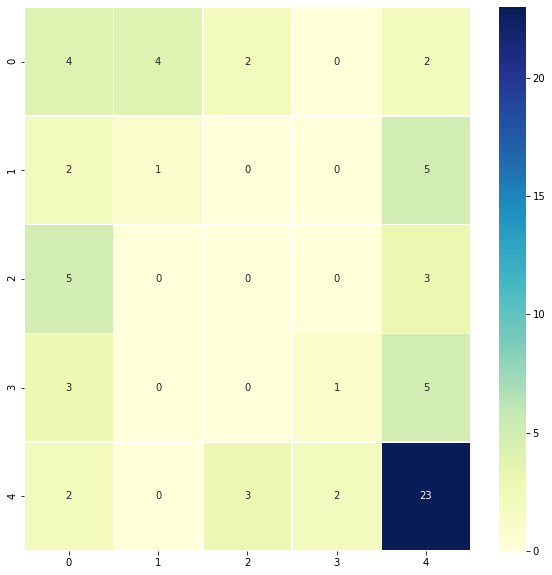

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 10))
confusion_df = pd.DataFrame(confusion, index=range(5), columns=range(5))
axes = sns.heatmap(confusion_df, annot=True,cmap='YlGnBu',fmt="d",linewidths=.5)

# Classification Report

In [12]:
from sklearn.metrics import classification_report

print(classification_report(actual_ratings, predicted_ratings))

              precision    recall  f1-score   support

           1       0.25      0.33      0.29        12
           2       0.20      0.12      0.15         8
           3       0.00      0.00      0.00         8
           4       0.33      0.11      0.17         9
           5       0.61      0.77      0.68        30

    accuracy                           0.43        67
   macro avg       0.28      0.27      0.26        67
weighted avg       0.38      0.43      0.39        67



## --------------------------------------------------REPORT-------------------------------------------------------------------

## Since I have taken the reviews and ratings from the users there may be some uncertanity in reviews and ratings.
## Therefore the total accuracy for predicting the ratings from the user's reviews is nearly 50%

## ---------------------------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------

# SIMILARITY ANALYSIS

# Dataset1 contains critic names and reviews for the movie JOKER
# Dataset2 contains critic names and reviews for the movie PARASITE

In [13]:
import pandas as pd
import spacy
nlk=spacy.load('en')

dataset1=pd.read_csv('joker_movie.csv')
dataset2=pd.read_csv('parasite_movie.csv')

# CLEANING DATA -- converting into lowercase and removing the punctuations

In [14]:
import re
import string
clean_reviews1=[]
clean_reviews2=[]
def datacleaning(text):
    text=text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    return text
for text in dataset1['review']:
    data=datacleaning(text)
    clean_reviews1.append(data)
for text in dataset2['reviews']:
    data=datacleaning(text)
    clean_reviews2.append(data)
dataset1.drop(['review'],axis=1,inplace=True)
dataset2.drop(['reviews'],axis=1,inplace=True)
dataset1['reviews']=pd.DataFrame(clean_reviews1)
dataset2['reviews']=pd.DataFrame(clean_reviews2)

In [15]:
dataset1

,film_critic,reviews
0,James Berardinelli,in the batman universe there are two kinds of ...
1,roger edbert,in mainstream movies today dark is just anothe...
2,peter travers,for the first time the man who laughs gets the...
3,armond white,oaquin phoenixs performance in joker might hav...


In [16]:
dataset2

,film_critic,reviews
0,James Berardinelli,parasite opens with a stark reminder that the ...
1,roger edbert,its so clichéd at this point in the critical c...
2,peter travers,a bloodsoaked fable the latest from south kore...
3,armond white,nothing in bong joonhos parasite matches the b...


# Performing the Similarity analysis on each review of dataset1 to the each review of dataset 2

In [17]:
import warnings
warnings.filterwarnings('ignore')
values=[]
for c1,r1 in zip(dataset1['film_critic'],dataset1['reviews']):
    for c2,r2 in zip(dataset2['film_critic'],dataset2['reviews']):
        document1=nlk(r1)
        document2=nlk(r2)
        sim=document1.similarity(document2)
        if c1 == c2 and sim > 0.97:
            z = 'True Positive'
        elif c1 == c2 and sim < 0.97:
            z = 'True Negative'
        elif c1 != c2 and sim > 0.97:
            z = 'False Positive'
            
        elif c1 != c2 and sim < 0.97:
            z = 'False Negative'
        values.append(z)
        print(f'The similarity between {c1} and {c2} is {(sim*100)}% and its {z}')

The similarity between James Berardinelli and James Berardinelli is 97.85987981267806% and its True Positive
The similarity between James Berardinelli and roger edbert is 96.36985804812176% and its False Negative
The similarity between James Berardinelli and peter travers is 96.85903458752315% and its False Negative
The similarity between James Berardinelli and armond white is 97.61434403725688% and its False Positive
The similarity between roger edbert and James Berardinelli is 95.15905751467389% and its False Negative
The similarity between roger edbert and roger edbert is 98.52892534070446% and its True Positive
The similarity between roger edbert and peter travers is 93.7131758109621% and its False Negative
The similarity between roger edbert and armond white is 91.44935323926677% and its False Negative
The similarity between peter travers and James Berardinelli is 94.57510632311845% and its False Negative
The similarity between peter travers and roger edbert is 94.6793547110132% a

In [18]:
from collections import *
true_false_count = Counter(values)
print(f'The number of false negatives and false positives are \n {true_false_count}')

The number of false negatives and false positives are 
 Counter({'False Negative': 11, 'True Positive': 3, 'False Positive': 1, 'True Negative': 1})


In [19]:
accuracy = (true_false_count['False Negative']+true_false_count['True Positive'])/sum(true_false_count.values())*100
print(f'The accuracy of the similarity analysis is {accuracy}')

The accuracy of the similarity analysis is 87.5
